In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
pd.set_option('display.max_columns', None)

# load feature-engineered data
df = pd.read_csv("../data/social_media_ad_optimization_raw.csv")
df.shape
df.head()


,user_id,age,gender,location,interests,ad_id,ad_category,ad_platform,ad_type,impressions,clicks,conversion,time_spent_on_ad,day_of_week,device_type,engagement_score
0,U0001,58,M,USA,Food,A0001,Sportswear,Facebook,Image,3,0,0,3.38,Friday,Mobile,0.02
1,U0002,55,F,USA,Tech,A0002,Electronics,Facebook,Image,9,9,1,6.77,Saturday,Tablet,0.93
2,U0003,52,F,UK,Gaming,A0003,Luggage,Instagram,Image,13,12,1,13.26,Wednesday,Mobile,0.93
3,U0004,31,F,USA,Tech,A0004,Gadgets,Facebook,Video,14,5,0,24.41,Saturday,Desktop,0.28
4,U0005,52,M,India,Tech,A0005,Luggage,Instagram,Carousel,10,5,0,21.43,Monday,Tablet,0.35


In [27]:
df["time_spent_on_ad"].describe()

count    500.000000
mean      14.072300
std        9.088768
min        0.460000
25%        4.990000
50%       13.285000
75%       21.732500
max       29.950000
Name: time_spent_on_ad, dtype: float64

In [15]:
df = df.drop(columns=["engagement_score"])

In [16]:
X = df.drop(columns=["user_id", "ad_id", "conversion"])
y = df["conversion"]


In [17]:
numeric_features = ["age", "impressions", "clicks", "time_spent_on_ad"]
categorical_features = [
    "gender", "location", "interests",
    "ad_category", "ad_platform",
    "ad_type", "day_of_week", "device_type"
]


**Preprocessing Pipeline**

In [18]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

**Logistic Regression Pipeline**

In [19]:
clf_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=300))
])


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
clf_lr.fit(X_train, y_train)

/Users/shithilshetty/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/shithilshetty/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/shithilshetty/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/shithilshetty/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/shithilshetty/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_fea

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'impressions',
                                                   'clicks',
                                                   'time_spent_on_ad']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'location',
                                                   'interests', 'ad_category',
                                                   'ad_platform', 'ad_type',
                                                   'day_of_week',
                                                   'device_type'])])),
                ('clf', LogisticRegression(max_iter=300))])

In [21]:
preds = clf_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.54      0.57      0.56        54
           1       0.47      0.43      0.45        46

    accuracy                           0.51       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.51      0.51      0.51       100



/Users/shithilshetty/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shithilshetty/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shithilshetty/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [22]:
clf_model = clf_lr.named_steps["clf"]

feature_names = []
for name, transformer, cols in clf_lr.named_steps["preprocessor"].transformers_:
    if hasattr(transformer, "get_feature_names_out"):
        names = transformer.get_feature_names_out(cols)
    else:
        names = cols
    feature_names.extend(names)

coef = clf_model.coef_[0]
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
}).sort_values("coefficient", ascending=False)

feat_imp.head(20)


,feature,coefficient
17,ad_category_Food & Beverage,0.575884
5,gender_Other,0.473112
2,clicks,0.394502
3,time_spent_on_ad,0.359669
21,ad_platform_Instagram,0.167801
6,location_Canada,0.118574
25,day_of_week_Saturday,0.111670
22,ad_type_Image,0.086763
29,day_of_week_Wednesday,0.076435
12,interests_Food,0.052901


In [23]:
X_transformed = clf_lr.named_steps['preprocessor'].transform(df.drop(columns=["user_id","ad_id","conversion"]))


coef = clf_lr.named_steps['clf'].coef_[0]
intercept = clf_lr.named_steps['clf'].intercept_[0]
linear_score = np.dot(X_transformed, coef) + intercept

# Scale linear score to 0–1
scaler = MinMaxScaler()
df['engagement_score_supervised'] = scaler.fit_transform(linear_score.reshape(-1,1))

# Check results
df[['user_id','clicks','time_spent_on_ad','ad_platform','ad_category','engagement_score_supervised']].head()


,user_id,clicks,time_spent_on_ad,ad_platform,ad_category,engagement_score_supervised
0,U0001,0,3.38,Facebook,Sportswear,0.416418
1,U0002,9,6.77,Facebook,Electronics,0.427514
2,U0003,12,13.26,Instagram,Luggage,0.609831
3,U0004,5,24.41,Facebook,Gadgets,0.453463
4,U0005,5,21.43,Instagram,Luggage,0.329103


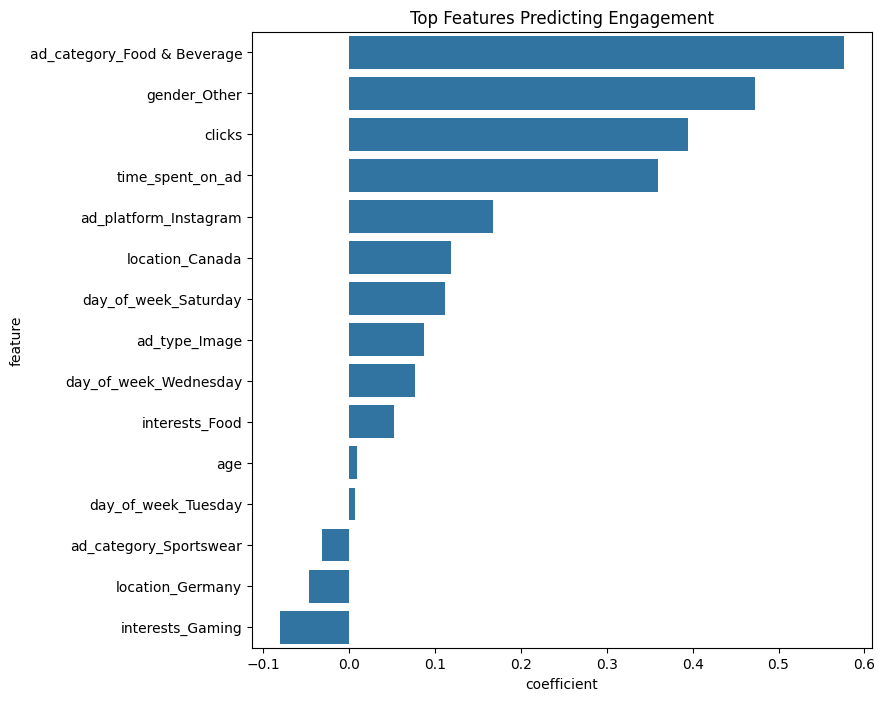

In [24]:
plt.figure(figsize=(8,8))
sns.barplot(data=feat_imp.head(15), x="coefficient", y="feature")
plt.title("Top Features Predicting Engagement")
plt.show()

Top positive predictors (increase engagement):
- Food & Beverage ads show the strongest lift in engagement
- Users labeled as "Other" gender category engage more
- Clicks & time_spent_on_ad are naturally strong engagement drivers
- Instagram platform users tend to show higher engagement
- Canadian users are more engaged
- Saturday ads perform consistently well

Negative predictors (reduce engagement):
- High impressions without interaction reduce engagement score
- Gadget category ads show lower engagement
- Thursday/Sunday ads tend to underperform

**Best combination of day_of_week and device_type**

In [28]:
# Cell 1 — imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings("ignore")

# Try XGBoost, fallback to sklearn's HistGradientBoostingClassifier
try:
    from xgboost import XGBClassifier
    MODEL_NAME = "xgboost"
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier as XGBClassifier
    MODEL_NAME = "sklearn_hgb"
print("Using model:", MODEL_NAME)

Using model: sklearn_hgb


In [ ]:
df = pd.read_csv("../data/social_media_ad_optimization_raw.csv")
df.shape, df.columns.tolist()

((500, 16),
 ['user_id',
  'age',
  'gender',
  'location',
  'interests',
  'ad_id',
  'ad_category',
  'ad_platform',
  'ad_type',
  'impressions',
  'clicks',
  'conversion',
  'time_spent_on_ad',
  'day_of_week',
  'device_type',
  'engagement_score'])

In [30]:
# Cell 3 — basic cleaning & target/features selection
# Drop rows with missing conversion (if any)
df = df.dropna(subset=["conversion"]).reset_index(drop=True)

# Define target
target = "conversion"   # 0/1

# Drop identifiers
drop_cols = ["user_id","ad_id"]
for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=[c])

# Candidate numeric and categorical features (adjust if columns missing)
numeric_features = [c for c in ["age","impressions","clicks","time_spent_on_ad"] if c in df.columns]
categorical_features = [c for c in ["gender","location","interests","ad_category","ad_platform","ad_type","day_of_week","device_type"] if c in df.columns]

print("numeric:", numeric_features)
print("categorical:", categorical_features)


numeric: ['age', 'impressions', 'clicks', 'time_spent_on_ad']
categorical: ['gender', 'location', 'interests', 'ad_category', 'ad_platform', 'ad_type', 'day_of_week', 'device_type']


In [31]:
# Cell 4 — quick train/test split (stratify on conversion)
X = df[numeric_features + categorical_features]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape, "Positive rate (train):", y_train.mean())


Train: (400, 12) Test: (100, 12) Positive rate (train): 0.47


In [33]:
# Cell 5 — preprocessing pipeline
# numeric: impute median then scale
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# categorical: impute mode (simple) then one-hot
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)
], remainder="drop")


In [34]:
# Cell 6 — build model pipeline
# XGBClassifier if available; else sklearn HGB
if MODEL_NAME == "xgboost":
    clf = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )
else:
    # HistGradientBoostingClassifier interface
    clf = XGBClassifier(
        max_iter=300,
        learning_rate=0.05,
        random_state=42
    )

pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", clf)
])


In [35]:
# Cell 7 — train with a small validation set for early stopping (if XGBoost)
if MODEL_NAME == "xgboost":
    # For xgboost we can use early stopping by extracting DMatrix — easier to use sklearn wrapper with eval_set
    # Fit with eval_set on a held-out split from the training set
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0, stratify=y_train)
    # fit preprocessor first to transform data for XGBoost's early stopping (sklearn pipeline with eval_set is supported only in newer versions)
    X_tr_prep = preprocessor.fit_transform(X_tr)
    X_val_prep = preprocessor.transform(X_val)
    # Fit the classifier directly with prepared matrices
    clf.fit(X_tr_prep, y_tr, early_stopping_rounds=25, eval_set=[(X_val_prep, y_val)], verbose=False)
    # attach preprocessor to pipeline for downstream use
    pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
else:
    # For sklearn HGB or fallback, just fit pipeline
    pipe.fit(X_train, y_train)

In [36]:
# Cell 8 — evaluate on test set
# Make sure pipeline is ready (if xgboost we attached preprocessor)
pipe.fit(X_train, y_train) if MODEL_NAME != "xgboost" else None

y_proba = pipe.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

print("Test ROC-AUC:", round(roc_auc_score(y_test, y_proba),4))
print(classification_report(y_test, y_pred))


Test ROC-AUC: 0.5576
              precision    recall  f1-score   support

           0       0.63      0.49      0.55        53
           1       0.54      0.68      0.60        47

    accuracy                           0.58       100
   macro avg       0.59      0.59      0.58       100
weighted avg       0.59      0.58      0.58       100



In [38]:
# Cell 9 — Function: compute best day-device pairs per country
def best_day_device_by_country(pipe, df, numeric_features, categorical_features, country_col="location", day_col="day_of_week", device_col="device_type", topk=3):
    results = []
    countries = df[country_col].dropna().unique()
    # full list of days & devices in data
    days_all = df[day_col].dropna().unique()
    devices_all = df[device_col].dropna().unique()

    for country in countries:
        sub = df[df[country_col] == country]
        if sub.shape[0] == 0:
            continue
        # baseline values from country-specific subset
        baseline = {}
        for f in numeric_features:
            baseline[f] = sub[f].median() if f in sub.columns else 0
        for f in categorical_features:
            # pick the most common category in that country for other categorical features
            if f in [day_col, device_col, country_col]:
                continue
            baseline[f] = sub[f].mode().iloc[0] if (f in sub.columns and sub[f].notna().any()) else None

        rows = []
        for d in days_all:
            for dv in devices_all:
                row = baseline.copy()
                row[day_col] = d
                row[device_col] = dv
                # if some categorical baseline None, fill with global mode
                for f in categorical_features:
                    if f not in row or row[f] is None:
                        row[f] = df[f].mode().iloc[0] if f in df.columns else None
                rows.append(row)
        grid = pd.DataFrame(rows)
        # Ensure column order
        features_used = numeric_features + [c for c in categorical_features if c in grid.columns]
        X_grid = grid[features_used]
        # Preprocess + predict
        Xp = pipe.named_steps['pre'].transform(X_grid)
        probs = pipe.named_steps['clf'].predict_proba(Xp)[:,1]
        grid['pred_proba'] = probs
        grid['country'] = country
        # select topk
        top = grid.sort_values('pred_proba', ascending=False).head(topk)
        for _, r in top.iterrows():
            results.append({
                'country': country,
                'day_of_week': r[day_col],
                'device_type': r[device_col],
                'predicted_conversion_prob': r['pred_proba']
            })
    return pd.DataFrame(results)

In [39]:
# Cell 10 — run the best-combo computation (top 3 per country)
results = best_day_device_by_country(pipe, df, numeric_features, categorical_features, country_col="location", day_col="day_of_week", device_col="device_type", topk=3)
results_sorted = results.sort_values(["country","predicted_conversion_prob"], ascending=[True,False]).reset_index(drop=True)
results_sorted

,country,day_of_week,device_type,predicted_conversion_prob
0,Australia,Saturday,Desktop,0.747924
1,Australia,Saturday,Mobile,0.588616
2,Australia,Saturday,Tablet,0.566612
3,Canada,Saturday,Desktop,0.875846
4,Canada,Saturday,Tablet,0.774228
5,Canada,Friday,Desktop,0.730824
6,Germany,Saturday,Desktop,0.948345
7,Germany,Saturday,Mobile,0.931292
8,Germany,Saturday,Tablet,0.864093
9,India,Saturday,Desktop,0.164108


In [40]:
# Cell 11 — Save model and results
Path("models").mkdir(parents=True, exist_ok=True)
joblib.dump(pipe, "models/xgb_conversion_pipe.joblib")
Path("reports").mkdir(parents=True, exist_ok=True)
results_sorted.to_csv("reports/best_day_device_by_country.csv", index=False)
print("Saved model and CSV report.")

Saved model and CSV report.


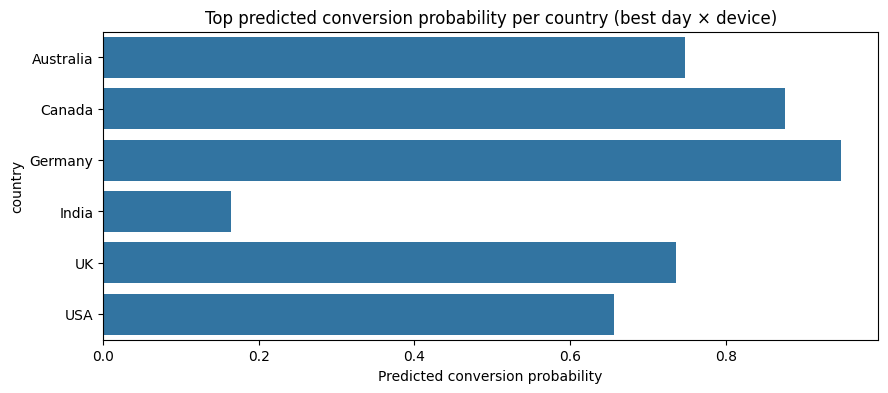

In [ ]:
top1 = results_sorted.groupby("country").first().reset_index()
plt.figure(figsize=(10, max(4, len(top1)*0.5)))
sns.barplot(data=top1, x="predicted_conversion_prob", y="country")
plt.title("Top predicted conversion probability per country (best day × device)")
plt.xlabel("Predicted conversion probability")
plt.show()

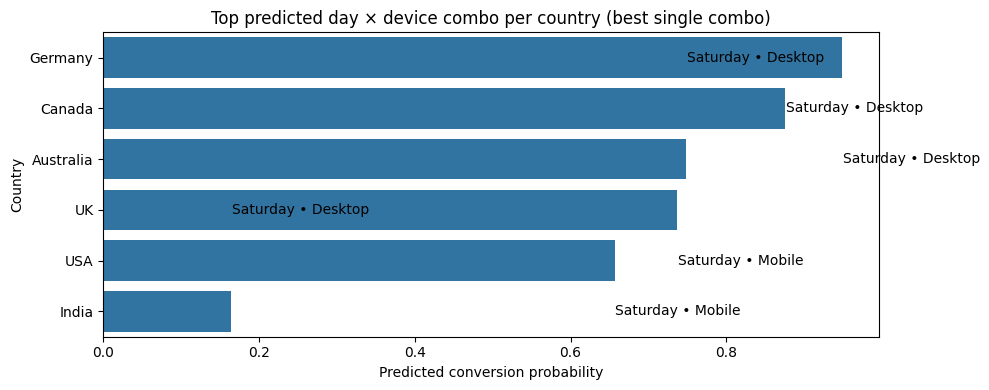

In [42]:
# get top-1 per country
top1 = results_sorted.groupby("country").first().reset_index()

plt.figure(figsize=(10, max(4, len(top1)*0.5)))
sns.barplot(data=top1.sort_values("predicted_conversion_prob", ascending=False),
            x="predicted_conversion_prob", y="country")
plt.xlabel("Predicted conversion probability")
plt.ylabel("Country")
plt.title("Top predicted day × device combo per country (best single combo)")
for i,row in top1.iterrows():
    plt.text(row['predicted_conversion_prob']+0.001, i, f"{row['day_of_week']} • {row['device_type']}", va='center')
plt.tight_layout()
plt.show()


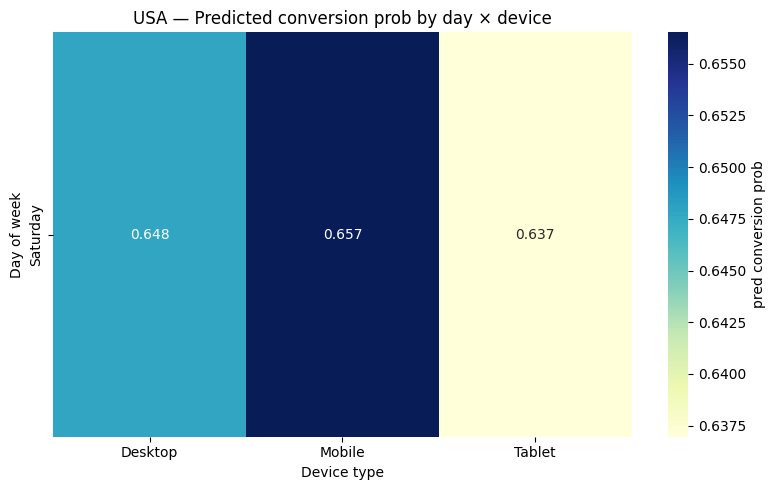

In [48]:
def plot_heatmap_for_country(country):
    sub = results_sorted[results_sorted['country']==country]
    if sub.empty:
        print("No results for", country); return
    pivot = sub.pivot_table(index='day_of_week', columns='device_type', values='predicted_conversion_prob', aggfunc='mean')
    plt.figure(figsize=(8,5))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label':'pred conversion prob'})
    plt.title(f"{country} — Predicted conversion prob by day × device")
    plt.ylabel("Day of week"); plt.xlabel("Device type")
    plt.tight_layout(); plt.show()

plot_heatmap_for_country(top1['country'].iloc[1])

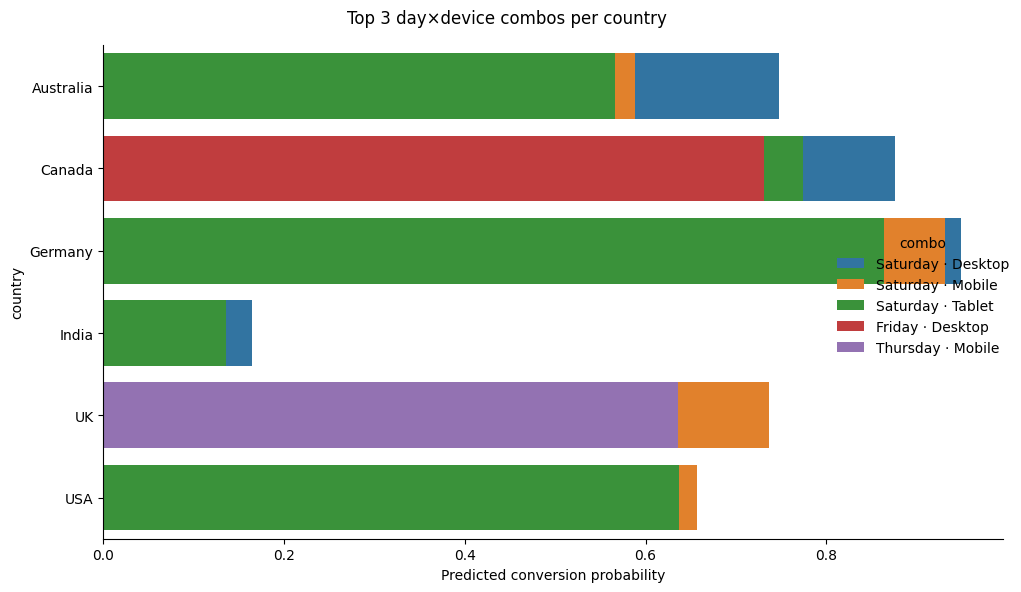

In [45]:
# use results_sorted, keep top3 per country
top3 = results_sorted.groupby("country").head(3).copy()
top3['combo'] = top3['day_of_week'] + " · " + top3['device_type']

g = sns.catplot(data=top3, y='country', x='predicted_conversion_prob', hue='combo', kind='bar',
                height=6, aspect=1.4, dodge=False)
g.fig.suptitle("Top 3 day×device combos per country")
g.set_xlabels("Predicted conversion probability")
plt.tight_layout()
plt.show()

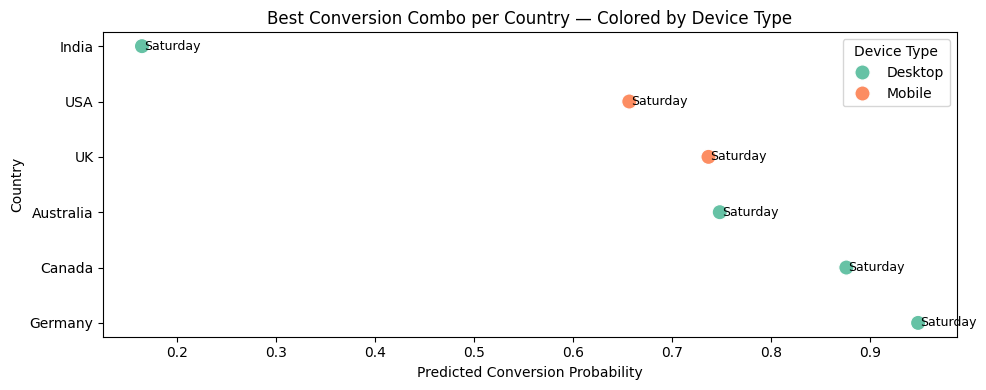

In [47]:
top1 = results_sorted.groupby("country").first().reset_index()
top1 = top1.sort_values("predicted_conversion_prob", ascending=True)

plt.figure(figsize=(10, max(4, len(top1)*0.5)))

sns.scatterplot(
    data=top1,
    x="predicted_conversion_prob",
    y="country",
    hue="device_type",
    palette="Set2",
    s=120
)

for idx, row in top1.iterrows():
    plt.text(row['predicted_conversion_prob'] + 0.002,
             row['country'],
             row['day_of_week'],
             va='center', fontsize=9)

plt.title("Best Conversion Combo per Country — Colored by Device Type")
plt.xlabel("Predicted Conversion Probability")
plt.ylabel("Country")
plt.legend(title="Device Type")
plt.tight_layout()
plt.show()